# Exploratory Data Analysis

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import feather
import numpy as np
import pandas as pd
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt

from collections import namedtuple

In [3]:
df_meta = pd.read_feather('../metadata/df_meta.fth')

## Extreme Values Check

We expect the values of the voxels we want to see to be within the range of [hounsfield units](https://radiopaedia.org/articles/hounsfield-unit) which is -1000 to 1000. For this analysis, we check the maximum and minimum voxels for all CT scans

In [4]:
df_meta_trn = df_meta[df_meta.is_valid==False]
df_meta_val = df_meta[df_meta.is_valid==True]

In [5]:
# To reiterate, nifti get_fdata() function already casted the datatype to float which is why the int16 row is showing floating point values
index = ['bitpix','datatype']
values=['img_mean','img_std','img_max','img_min','uid']
aggfunc={'img_mean':'mean', 'img_std':'mean','img_max':'max','img_min':'min','uid':'count'}
df_meta_trn.pivot_table(values=values, index=index, aggfunc=aggfunc)

,,img_max,img_mean,img_min,img_std,uid
bitpix,datatype,,,,,
16,4,32737.0,-882.208554,-10380.0,722.671307,196
64,64,6269.0,-897.503456,-2048.0,747.075140,3


In [6]:
df_meta_val.pivot_table(values=values, index=index, aggfunc=aggfunc)

,,img_max,img_mean,img_min,img_std,uid
bitpix,datatype,,,,,
16,4,32767.0,-885.082206,-8128.0,725.012770,49
64,64,6862.0,-781.063345,-2431.0,796.516074,1


It is quite concerning that the range of values are so large, especially for the 16bit volumes. The range for voxels should not be so large as the relevant data usually lies within a small range of housefield units (-1000,1000). If the range is large then we need to check the distribution of pixels to see how much of the data is present in the extreme ranges.

In [7]:
def distrib_summ(t, ax):
    ax.hist(t,40)
    return np.array([t.min(),*np.percentile(t,[0.1,1,5,50,95,99,99.9]),t.max()], dtype=np.int)

In [8]:
df_16_trn = df_meta_trn.query('bitpix==16')
df_16_val = df_meta_val.query('bitpix==16')

[ 1348  1360  1431  1569  2453 24635 31714 32663 32737]
[-10380 -10238  -9025  -6925  -2048  -1161  -1024  -1024  -1024]
[ 1347  1350  1383  1660  3106 23132 29743 32464 32767]
[-8128 -8076 -7617 -5253 -2048 -1541 -1087 -1030 -1024]


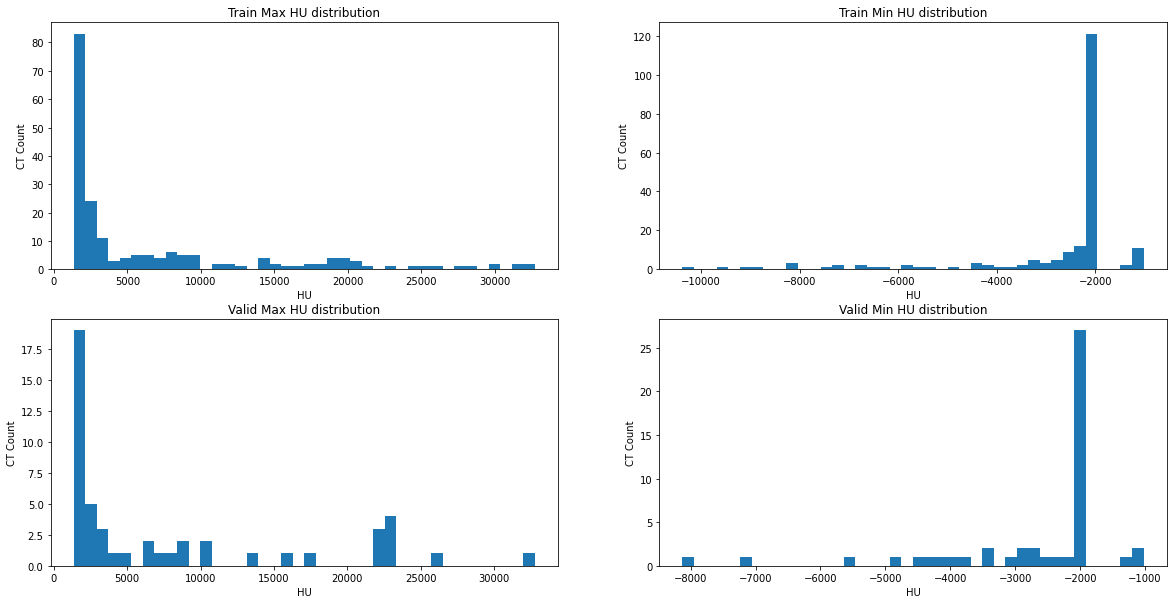

In [9]:
def plot_dists(df1,df2):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
    axes[0][0].title.set_text('Train Max HU distribution')
    axes[0][1].title.set_text('Train Min HU distribution')
    axes[1][0].title.set_text('Valid Max HU distribution')
    axes[1][1].title.set_text('Valid Min HU distribution')
    for i in range(2):
        for j in range(2):
            axes[i][j].set_xlabel('HU')
            axes[i][j].set_ylabel('CT Count')
    print(distrib_summ(df1.img_max.values,axes[0][0]))
    print(distrib_summ(df1.img_min.values,axes[0][1]))
    print(distrib_summ(df2.img_max.values,axes[1][0]))
    print(distrib_summ(df2.img_min.values,axes[1][1]))
plot_dists(df_16_trn, df_16_val)

In [10]:
df_64_trn = df_meta_trn.query('bitpix==64')
df_64_val = df_meta_val.query('bitpix==64')

[2253 2253 2254 2262 2348 5876 6190 6261 6269]
[-2048 -2048 -2048 -2048 -2048 -2048 -2048 -2048 -2048]
[6862 6862 6862 6862 6862 6862 6862 6862 6862]
[-2431 -2431 -2431 -2431 -2431 -2431 -2431 -2431 -2431]


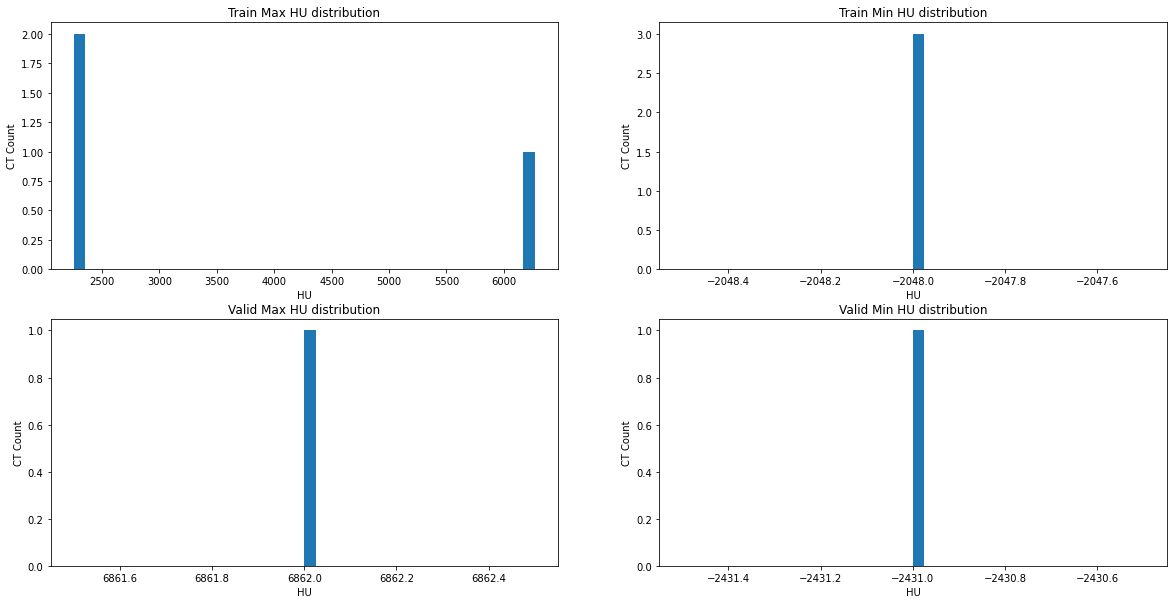

In [11]:
plot_dists(df_64_trn, df_64_val)

A relevant amount of volumes have their max and min values in extreme ranges. Thankfully, the standard deviation of voxel values is roughly around 700 which can lie in the relevant range so now all we need to do is to check the distribution of voxels.  If the distribution falls within the hounsfield units range then we clip the scans and visualize the outcome of this.

## Distribution Analysis

### HU Voxel distribution

In [12]:
len(df_64_trn), len(df_64_val)

(3, 1)

In [13]:
scans_64_trn = [nib.load(f).get_fdata() for f in df_64_trn.ct_fname]
scans_64_val = [nib.load(f).get_fdata() for f in df_64_val.ct_fname]

In [14]:
def plot_hu_hist(scans_trn, scans_val):
    colors = ['#293faf', '#a4a2f5', '#b5804e', '#188e47', '#adcca0', '#ae311a', '#fea788', '#c172a7', '#ab7c1a', '#fe0087']
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    ax[0].set_title(f'HU distributions for {len(scans_trn)} train examples')
    ax[1].set_title(f'HU distributions for {len(scans_val)} valid examples')
    for i in range(len(scans_trn)):
        image = scans_trn[i].flatten()
        sns.histplot(image, ax=ax[0], color=colors[i], bins=40)
    for i in range(len(scans_val)):
        image = scans_val[i].flatten()
        sns.histplot(image, ax=ax[1], color=colors[i], bins=40)

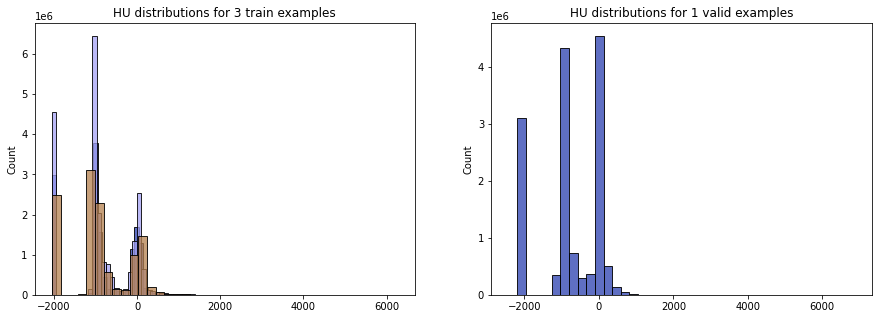

In [28]:
plot_hu_hist(scans_64_trn, scans_64_val)

In [15]:
len(df_16_trn), len(df_16_val)

(196, 49)

In [30]:
scans_16_trn = [nib.load(f).get_fdata() for f in df_16_trn.sample(10, random_state=23).ct_fname]
scans_16_val = [nib.load(f).get_fdata() for f in df_16_val.sample(10, random_state=23).ct_fname]

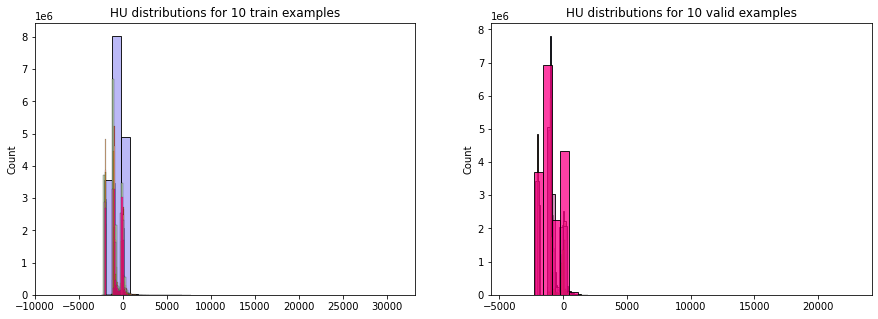

In [31]:
plot_hu_hist(scans_16_trn, scans_16_val)

Most of the data is in the range that we want so we can most likely clip the data with little information loss

### Distributions of true positive labels

count    199.000000
mean       0.437846
std        0.602369
min        0.003093
25%        0.085656
50%        0.226943
75%        0.522874
max        4.036325
Name: pct_lesion, dtype: float64

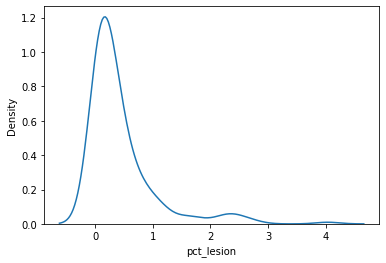

In [16]:
sns.kdeplot(data=(df_meta[df_meta.is_valid==False].pct_lesion * 100))
(df_meta[df_meta.is_valid==False].pct_lesion*100).describe()

It is apparent that there is a big class imbalance between positive and negative labels. This implies that we would need to do some preprocessing to our data since if we were to simply throw data at the model then it will likely result in unstable training

## Visually checking the effects of clipping

In [12]:
# num CT's with max HU greater than the 95th percentile
len(df_meta[df_meta.img_max > 24635])

12

In [13]:
# grab a ct that has max HU values greater than the 95th percentile
sample_extreme_ct = nib.load(df_meta[df_meta.img_max > 24635].iloc[0].ct_fname)

In [14]:
ct_a = sample_extreme_ct.get_fdata()
ct_pos = ct_a.clip(0) # remove the negative values
(ct_pos < 0).sum(), ct_pos.shape

(0, (512, 512, 91))

In [15]:
# get the slice with the most high values
z_slice= None
z_high=0.
for i in range(91):
    if ct_pos[:,:,i].sum() > z_high:
        z_high = ct_pos[:,:,i].sum()
        z_slice = ct_a[:,:,i]

In [16]:
def show_slices(slices):
    fig, axes = plt.subplots(1, len(slices), figsize=(10, 5))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap='bone', origin="lower")

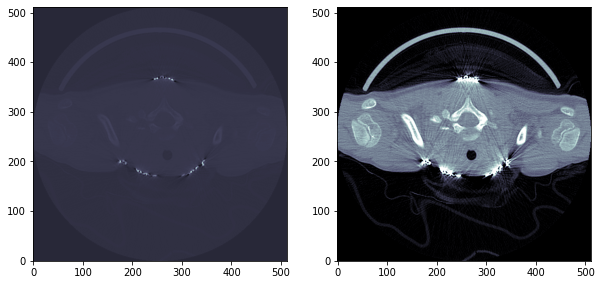

In [17]:
show_slices([z_slice, z_slice.clip(-1000,1000)])

Visually speaking, it looks like getting rid of the extreme values makes it weed out a lot of irrelevant information

## Visually checking the effects windowing

As per https://radiopaedia.org/articles/windowing-ct we will try to apply the typical windowing for chest scans

In [18]:
WindowInfo = namedtuple('WindowInfo', ['width', 'level'])

In [19]:
lung_window = WindowInfo(1500, -600)
mediastinal_window = WindowInfo(350, 50)

In [20]:
def window_image(img, window_center,window_width):
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    return img.clip(img_min, img_max)

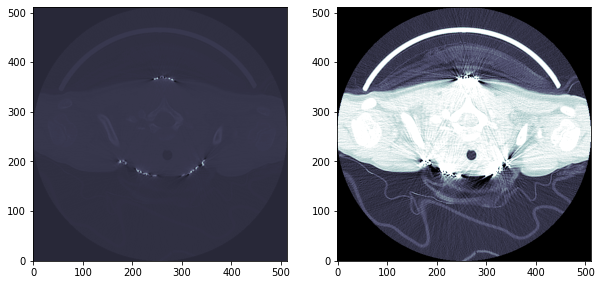

In [21]:
ct_lung = window_image(ct_a, lung_window.level, lung_window.width)
show_slices([z_slice, ct_lung[:,:,90]]) 

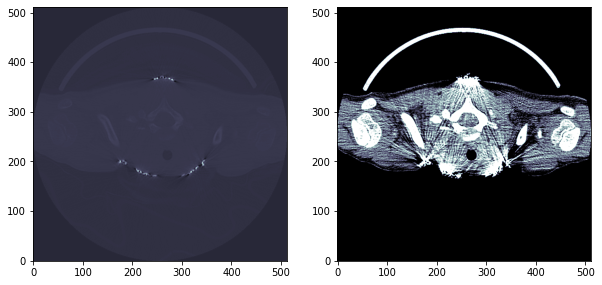

In [22]:
ct_lung = window_image(ct_a, mediastinal_window.level, mediastinal_window.width)
show_slices([z_slice, ct_lung[:,:,90]]) 

## Checking Lesion Distributions

After running some scipy magic, we were able to retrieve the center points of lesions along with their bounding box. We should check the sizes of our lesions by plotting the distribution of the largest side (basically the longest distance to the border from the center point; may be interpreted as the diameter)

In [4]:
df_lesion_coords = pd.read_feather('../metadata/df_lesion_coords.fth')

count    1237.000000
mean       33.232013
std        38.102532
min         1.000000
25%         7.000000
50%        20.000000
75%        44.000000
max       212.000000
Name: largest_side_px, dtype: float64

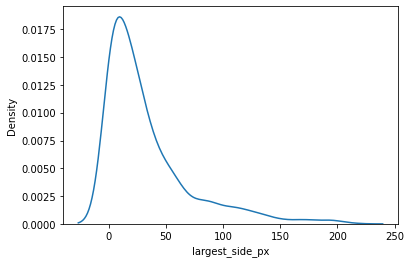

In [5]:
sns.kdeplot(data=df_lesion_coords.largest_side_px)
(df_lesion_coords.largest_side_px).describe()

The distribution is right skewed with some very large lesions at the far right and this presents quite an interesting problem. As shown previously, the number of voxels for non-lesions far outnumbers the lesion voxels so in order to have stable training we need to upsample by evening out the voxels. One method to do this is by simply zooming in to the areas with lesions.

For our upsampling during training, we will want to pick a sub-bounding box size small enough to fit a relevant amount of lesions but not too big so they still get overshadowed. Logically the large lesions will have the most information around them so it encourages to use a large enough bounding box that can fit them. Unfortunately this will drown out the majority of small lesions and if we pick one that is too small, it will not contain as much useful information.

As a sort of compromise, we will pick a semi-large bounding box size and sample a smaller bounding box from within it
